In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ancestrator import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


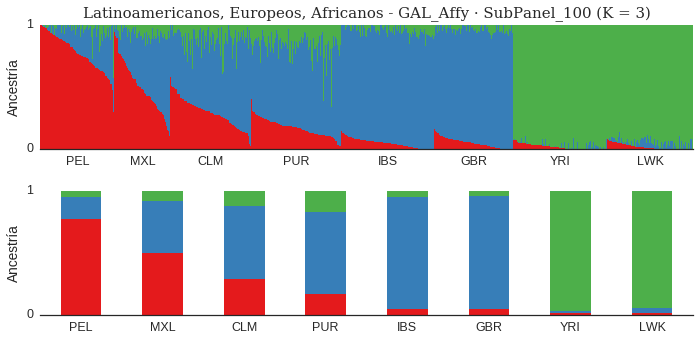

In [10]:
from itertools import product

sns.set_context('notebook',font_scale=1.25)
sns.set_style('white')

source_labels = ['1000Genomes']
samplegroup_labels = ['LEA']
panel_labels = [
 'GAL_Affy_SubPanel_100',
 'GAL_Affy_SubPanel_75',
 'GAL_Affy_SubPanel_60',
 'GAL_Affy_SubPanel_65',
 'GAL_Affy_SubPanel_50',
 'GAL_Affy_SubPanel_45',
 'GAL_Affy_SubPanel_40',
 'GAL_Affy_SubPanel_35',
 'GAL_Affy_SubPanel_30',
 'GAL_Affy_SubPanel_20',
 'GAL_Affy_SubPanel_10',
 'GAL_Affy_SubPanel_5'
]
Ks = [3]

combo = product(source_labels, panel_labels, samplegroup_labels)

for source_label, panel_label, samplegroup_label in combo:
    dataset = Dataset(source_label, samplegroup_label, panel_label)
    admixture = dataset.admixture(Ks=Ks, cores=4)

    for K in Ks:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
        admixture.plot(ax=ax1, K=K)
        admixture.plot(ax=ax2, K=K, population_means=True)
        ax2.set_title('')

        plt.tight_layout()
        plt.show()
    break

TernaryAxesSubplot: 8755779238590

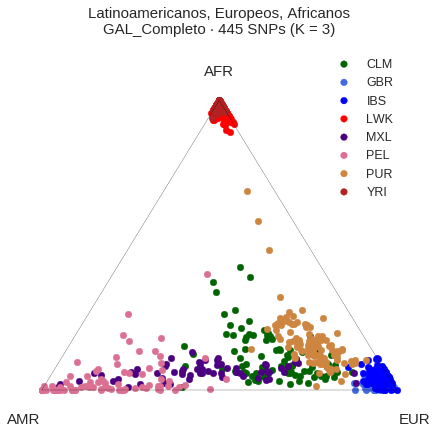

In [9]:
sns.set_style('white')

dataset = Dataset('1000Genomes', 'LEA', 'GAL_Completo')
admixture = dataset.admixture(Ks=[3])
admixture.plot_triangle()